In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os
import glob
import json
import warnings
import random
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from IPython.display import display
def calculate_mape(y_true, y_pred):
    # Tránh chia cho 0 bằng cách thêm một lượng rất nhỏ eps
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

def calculate_da(y_true, y_pred):
    true_diff = np.diff(y_true)
    pred_diff = np.diff(y_pred)
    correct_direction = (true_diff * pred_diff) > 0
    return np.mean(correct_direction) * 100
# Tắt cảnh báo
warnings.filterwarnings('ignore')

# Cấu hình Pandas để in ra HẾT CÁC CỘT (Không bị ...)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Thiết lập Random Seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Cấu hình thiết bị
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# --- CẤU HÌNH HYPERPARAMETERS ---
SEQ_LEN = 30
HIDDEN_DIM = 128
DROPOUT = 0.2
EPOCHS = 150
BATCH_SIZE = 32
LEARNING_RATE = 0.001
# --- CẤU HÌNH ĐƯỜNG DẪN ---
PRICE_DIR = os.path.join("..", "..", "DATASET", "PRICE")     
SENTIMENT_DIR = os.path.join("..", "..", "DATASET", "SENTIMENT")
CHART_DIR = os.path.join("..", "..", "CHART", "DLINEAR+NODE")
LOG_DIR = os.path.join("..", "..", "LOGS", "DLINEAR+NODE")

# Tạo thư mục nếu chưa tồn tại
os.makedirs(CHART_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

print(f"Thu muc CHART moi: {os.path.abspath(CHART_DIR)}")
print(f"Thu muc LOGS moi: {os.path.abspath(LOG_DIR)}")

Using device: cpu
Thu muc CHART moi: d:\NghienCuu\NCT3\CHART\DLINEAR+NODE
Thu muc LOGS moi: d:\NghienCuu\NCT3\LOGS\DLINEAR+NODE


In [8]:
class SentimentDLinearNodeModel(nn.Module):
    def __init__(self, seq_len=30, price_dim=5, sentiment_dim=10, hidden_dim=128, dropout=0.2):
        super().__init__()
        self.seq_len = seq_len
        self.price_dim = price_dim
        self.sentiment_dim = sentiment_dim
        
        # DLinear cho Price (Giống Hybrid)
        self.price_decomp = nn.Sequential(
            nn.Linear(seq_len, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, seq_len)
        )
        
        # DLinear cho Sentiment (Đã chỉnh: hidden_dim thay vì hidden_dim // 2)
        self.sentiment_decomp = nn.Sequential(
            nn.Linear(seq_len, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, seq_len)
        )
        
        # NODE (Neural ODE)
        self.node_layers = nn.Sequential(
            nn.Linear(price_dim + sentiment_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, price_dim + sentiment_dim)
        )
        
        # Predictor
        self.predictor = nn.Sequential(
            nn.Linear((price_dim + sentiment_dim) * seq_len, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
        
    def forward(self, price_x, sentiment_x):
        batch_size, seq_len, _ = price_x.shape
        combined_input = torch.cat([price_x, sentiment_x], dim=-1)
        
        price_trend = self.price_decomp(price_x.transpose(1, 2)).transpose(1, 2)
        sentiment_trend = self.sentiment_decomp(sentiment_x.transpose(1, 2)).transpose(1, 2)
        combined_trend = torch.cat([price_trend, sentiment_trend], dim=-1)
        
        node_output = combined_input + self.node_layers(combined_input)
        final_features = combined_trend + node_output
        
        flattened = final_features.reshape(batch_size, -1)
        output = self.predictor(flattened)
        return output

In [9]:
class DataProcessor:
    def __init__(self):
        self.price_scaler = StandardScaler()
        self.sentiment_scaler = StandardScaler()
        self.target_scaler = StandardScaler()

    def load_and_merge_data(self, price_path, sentiment_path):
        # 1. Đọc dữ liệu với encoding chuẩn
        price_df = pd.read_csv(price_path, encoding='utf-8-sig')
        sent_df = pd.read_csv(sentiment_path, encoding='utf-8-sig')

        # 2. Chuẩn hóa cột Ngày
        for df in [price_df, sent_df]:
            date_col = next((c for c in df.columns if c.lower() in ['ngày', 'date', 'time']), None)
            if date_col: df.rename(columns={date_col: 'Date'}, inplace=True)
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.normalize()

        # 3. Làm sạch dữ liệu Giá
        price_df = price_df.dropna(subset=['Date']).drop_duplicates('Date').sort_values('Date')
        
        # 4. Xử lý dữ liệu Sentiment (ÉP KIỂU SỐ TRƯỚC KHI GROUPBY)
        sent_df = sent_df.dropna(subset=['Date'])
        
        # Tìm các cột là chỉ số sentiment để xử lý
        sent_cols_to_process = [c for c in sent_df.columns if any(w in c.lower() for w in 
                               ['score', 'impact', 'relevance', 'sentiment', 'confidence', 'momentum', 'volatility', 'prob'])]
        
        for col in sent_cols_to_process:
            sent_df[col] = pd.to_numeric(sent_df[col], errors='coerce')
        
        # Gộp tin tức theo ngày (Tính trung bình các chỉ số)
        sent_df = sent_df.groupby('Date')[sent_cols_to_process].mean().reset_index()

        print(f" THỐNG KÊ FILE GỐC:")
        print(f"   1. Price     : {len(price_df)} dòng")
        print(f"   2. Sentiment : {len(sent_df)} dòng")
        print(f"   [Debug] Cột Sentiment tìm thấy: {sent_df.columns.tolist()}")

        # 5. Merge (Giữ nguyên lịch sử giá)
        merged_df = pd.merge(price_df, sent_df, on='Date', how='left')
        return merged_df

    def create_features(self, df):
        # Lấy cột giá
        price_cols = [c for c in ['Lần cuối', 'Mở', 'Cao', 'Thấp', 'Close', 'Open', 'High', 'Low'] if c in df.columns]
        price_feats = df[price_cols].copy()
        for col in price_cols:
            if price_feats[col].dtype == 'object':
                price_feats[col] = price_feats[col].str.replace(',', '').astype(float)
        price_feats = price_feats.ffill().bfill().fillna(0)

        # Lấy cột Sentiment (Đảm bảo lấy đúng các cột từ sent_df)
        sent_cols = [c for c in df.columns if any(word in c.lower() for word in 
                     ['score', 'impact', 'relevance', 'sentiment', 'confidence'])]
        
        if not sent_cols:
            # Fallback nếu không thấy cột (tránh lỗi rỗng)
            sent_feats = pd.DataFrame(0.0, index=df.index, columns=['placeholder_sentiment'])
        else:
            sent_feats = df[sent_cols].copy().fillna(0)

        target_col = next((c for c in ['Lần cuối', 'Close'] if c in df.columns), price_cols[0])
        return price_feats, sent_feats, df[target_col].values

    def prepare_sequences(self, price_feats, sent_feats, targets, stock_name, seq_len):
        # Chuyển sang float32
        p_data = price_feats.values.astype('float32')
        s_data = sent_feats.values.astype('float32')
        t_data = targets.astype('float32').reshape(-1, 1)

        p_scaled = self.price_scaler.fit_transform(p_data)
        s_scaled = self.sentiment_scaler.fit_transform(s_data)
        t_scaled = self.target_scaler.fit_transform(t_data).flatten()

        X_p, X_s, y = [], [], []
        for i in range(len(targets) - seq_len):
            X_p.append(p_scaled[i:i + seq_len])
            X_s.append(s_scaled[i:i + seq_len])
            y.append(t_scaled[i + seq_len])

        if not X_p:
            raise ValueError("Không tạo được sequence nào.")

        return np.array(X_p), np.array(X_s), np.array(y)

In [10]:
def get_performance_metrics(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # Sai số tuyệt đối và bình phương
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    # Sai số phần trăm (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Độ khớp (R2)
    r2 = r2_score(y_true, y_pred)
    
    # ĐỘ CHÍNH XÁC HƯỚNG (Directional Accuracy) - Quan trọng nhất để khoe Sentiment
    # Kiểm tra xem dự báo có đoán đúng hướng Tăng/Giảm so với ngày hôm trước không
    true_diff = np.diff(y_true) 
    pred_diff = y_pred[1:] - y_true[:-1] # Dự báo ngày t so với thực tế ngày t-1
    da = np.mean((true_diff * pred_diff) > 0) * 100
    
    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        "R2": r2,
        "DA (%)": da
    }

In [11]:
def train_model(model, train_loader, val_loader, stock_name, epochs=150):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()
    history = {"train_loss": [], "val_loss": []}
    
    print(f"Training {stock_name} (Sentiment Mode)...")
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for p, s, y in train_loader:
            p, s, y = p.to(DEVICE), s.to(DEVICE), y.to(DEVICE).unsqueeze(1)
            optimizer.zero_grad()
            loss = criterion(model(p, s), y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for p, s, y in val_loader:
                p, s, y = p.to(DEVICE), s.to(DEVICE), y.to(DEVICE).unsqueeze(1)
                v_loss += criterion(model(p, s), y).item()
        
        history["train_loss"].append(train_loss/len(train_loader))
        history["val_loss"].append(v_loss/len(val_loader))
        
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{epochs} - Loss: {history['train_loss'][-1]:.6f}")

    # Lưu model ở epoch cuối cùng 
    save_path = os.path.join(LOG_DIR, f"{stock_name}_Sentiment.pt")
    torch.save(model.state_dict(), save_path)
    return history, save_path

def visualize_prediction(model, X_p_tensor, X_s_tensor, y_tensor, stock_name, dates, mode, filename, processor):
    model.eval()
    with torch.no_grad():
        p_tensor = X_p_tensor.to(DEVICE)
        s_tensor = X_s_tensor.to(DEVICE)
        
        # 1. Dự báo và giải mã Inverse Transform
        preds_scaled = model(p_tensor, s_tensor).squeeze().cpu().numpy()
        targets_scaled = y_tensor.cpu().numpy()
        
        predictions = processor.target_scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
        targets = processor.target_scaler.inverse_transform(targets_scaled.reshape(-1, 1)).flatten()
    
    # 2. Xử lý ngày tháng (Chỉ lấy ngày/tháng)
    plot_dates = pd.to_datetime(dates)
    source_name = filename.replace('.csv', '')
    date_fmt = mdates.DateFormatter('%d/%m')

    # 3. Khởi tạo khung hình 2x2
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.25)

    # --- BIỂU ĐỒ [0, 0]: TỔNG THỂ ---
    axes[0, 0].plot(plot_dates, targets, label='Thực tế', color='blue', alpha=0.5, linewidth=1)
    axes[0, 0].plot(plot_dates, predictions, label='Dự báo', color='red', linestyle='--', alpha=0.8)
    axes[0, 0].set_title(f'Dự báo Tổng thể ({stock_name}) - {mode}')
    axes[0, 0].xaxis.set_major_formatter(date_fmt)
    axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)

    # --- BIỂU ĐỒ [0, 1]: ĐỘ LỆCH (SCATTER) ---
    axes[0, 1].scatter(targets, predictions, alpha=0.5, color='purple', s=10)
    axes[0, 1].plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'k--', lw=1)
    axes[0, 1].set_title('Tương quan Thực tế vs Dự báo')
    axes[0, 1].set_xlabel('Giá Thực tế'); axes[0, 1].set_ylabel('Giá Dự báo')

    # --- BIỂU ĐỒ [1, 0]: ZOOM 5 NGÀY CUỐI ---
    last_n = 5
    axes[1, 0].plot(plot_dates[-last_n:], targets[-last_n:], marker='o', label='Thực tế', color='blue')
    axes[1, 0].plot(plot_dates[-last_n:], predictions[-last_n:], marker='x', label='Dự báo', color='red', linestyle='--')
    axes[1, 0].set_title(f'{last_n} ngày cuối cùng')
    axes[1, 0].xaxis.set_major_formatter(date_fmt)
    axes[1, 0].legend(); axes[1, 0].grid(True)

    # --- BIỂU ĐỒ [1, 1]: SAI SỐ (%) ---
    error_pct = np.abs((targets - predictions) / (targets + 1e-9)) * 100
    axes[1, 1].bar(plot_dates[-20:], error_pct[-20:], color='orange', alpha=0.6)
    axes[1, 1].set_title('Sai số (%) - 20 ngày cuối')
    axes[1, 1].xaxis.set_major_formatter(date_fmt)
    axes[1, 1].set_ylabel('% Error')

    # 4. Tối ưu hiển thị
    fig.autofmt_xdate() # Xoay ngày tháng tự động
    
    # LƯU VÀ HIỂN THỊ (QUAN TRỌNG)
    plot_filename = f"{source_name}_{mode}_2x2.png"
    plt.savefig(os.path.join(CHART_DIR, plot_filename), bbox_inches='tight', dpi=150)
    
    plt.show() # Bắt buộc phải có dòng này để hiện trong Notebook
    plt.close(fig) # Sau đó mới đóng để giải phóng RAM

    # Trả về kết quả cho bảng tổng hợp
    m = get_performance_metrics(targets, predictions)
    
    metrics = {
        "Ticker": stock_name, # Đổi ticker thành stock_name để khớp với tham số đầu vào
        "Mode": mode,
        "MSE": m["MSE"],
        "RMSE": m["RMSE"],
        "MAE": m["MAE"],
        "MAPE (%)": m["MAPE (%)"],
        "R2": m["R2"],
        "DA (%)": m["DA (%)"],
        "Actual Last": targets[-1],
        "Pred Last": predictions[-1]
    }
    return metrics

Bắt đầu xử lý 11 mã cổ phiếu...

>>> ĐANG XỬ LÝ: ALIBABA.CSV | CHẾ ĐỘ: NAN_SENTIMENT
 THỐNG KÊ FILE GỐC:
   1. Price     : 2558 dòng
   2. Sentiment : 164 dòng
   [Debug] Cột Sentiment tìm thấy: ['Date']
Training ALIBABA.CSV_nan_sentiment (Sentiment Mode)...
Epoch 1/150 - Loss: 0.097248
Epoch 20/150 - Loss: 0.025568
Epoch 40/150 - Loss: 0.019119
Epoch 60/150 - Loss: 0.018373
Epoch 80/150 - Loss: 0.016387
Epoch 100/150 - Loss: 0.016492
Epoch 120/150 - Loss: 0.016230
Epoch 140/150 - Loss: 0.015422


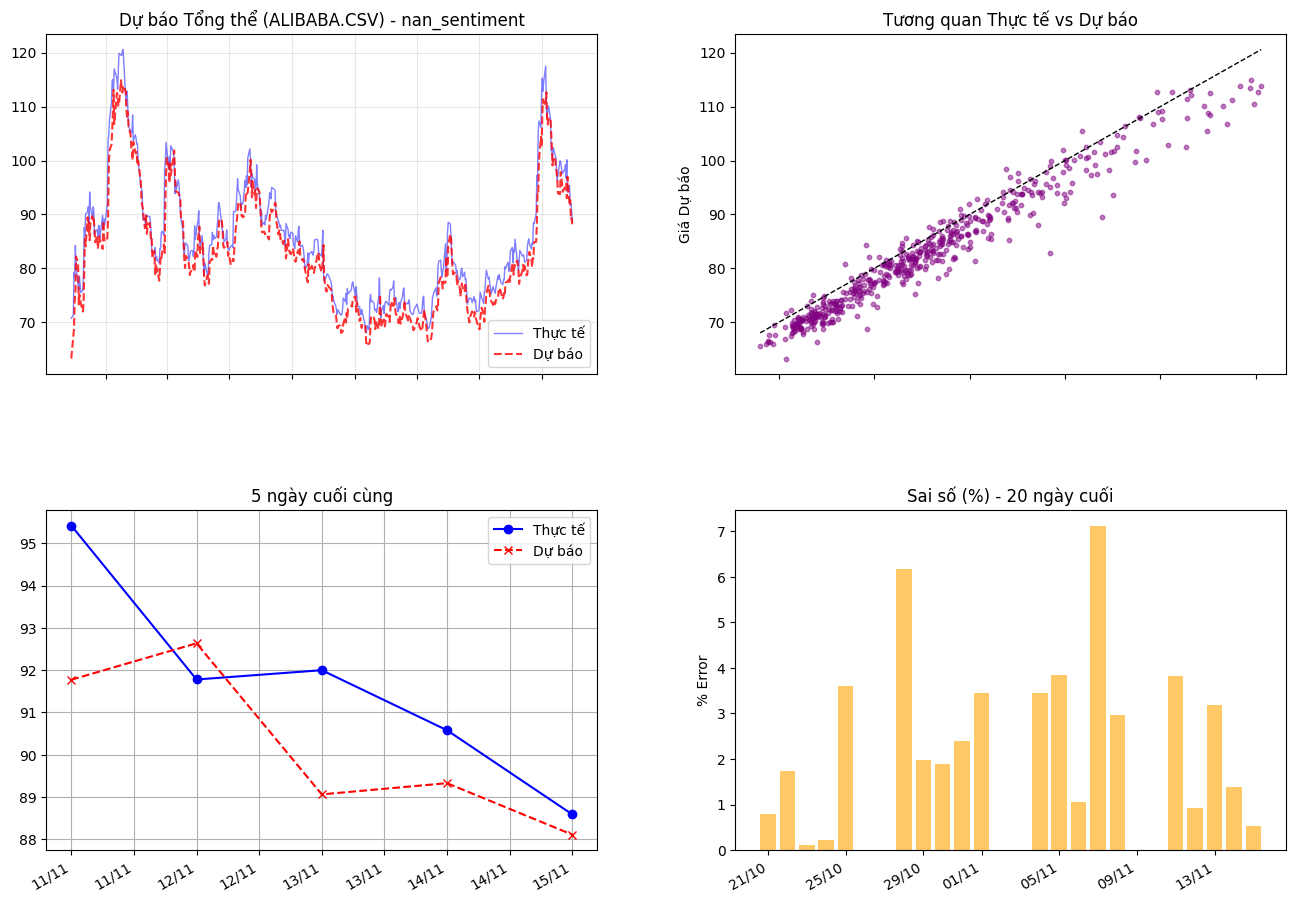


>>> ĐANG XỬ LÝ: ALIBABA.CSV | CHẾ ĐỘ: FULL_SENTIMENT
 THỐNG KÊ FILE GỐC:
   1. Price     : 2558 dòng
   2. Sentiment : 164 dòng
   [Debug] Cột Sentiment tìm thấy: ['Date']
Training ALIBABA.CSV_full_sentiment (Sentiment Mode)...
Epoch 1/150 - Loss: 0.124058
Epoch 20/150 - Loss: 0.022105
Epoch 40/150 - Loss: 0.019236
Epoch 60/150 - Loss: 0.015293
Epoch 80/150 - Loss: 0.016217
Epoch 100/150 - Loss: 0.014320
Epoch 120/150 - Loss: 0.015436
Epoch 140/150 - Loss: 0.015354


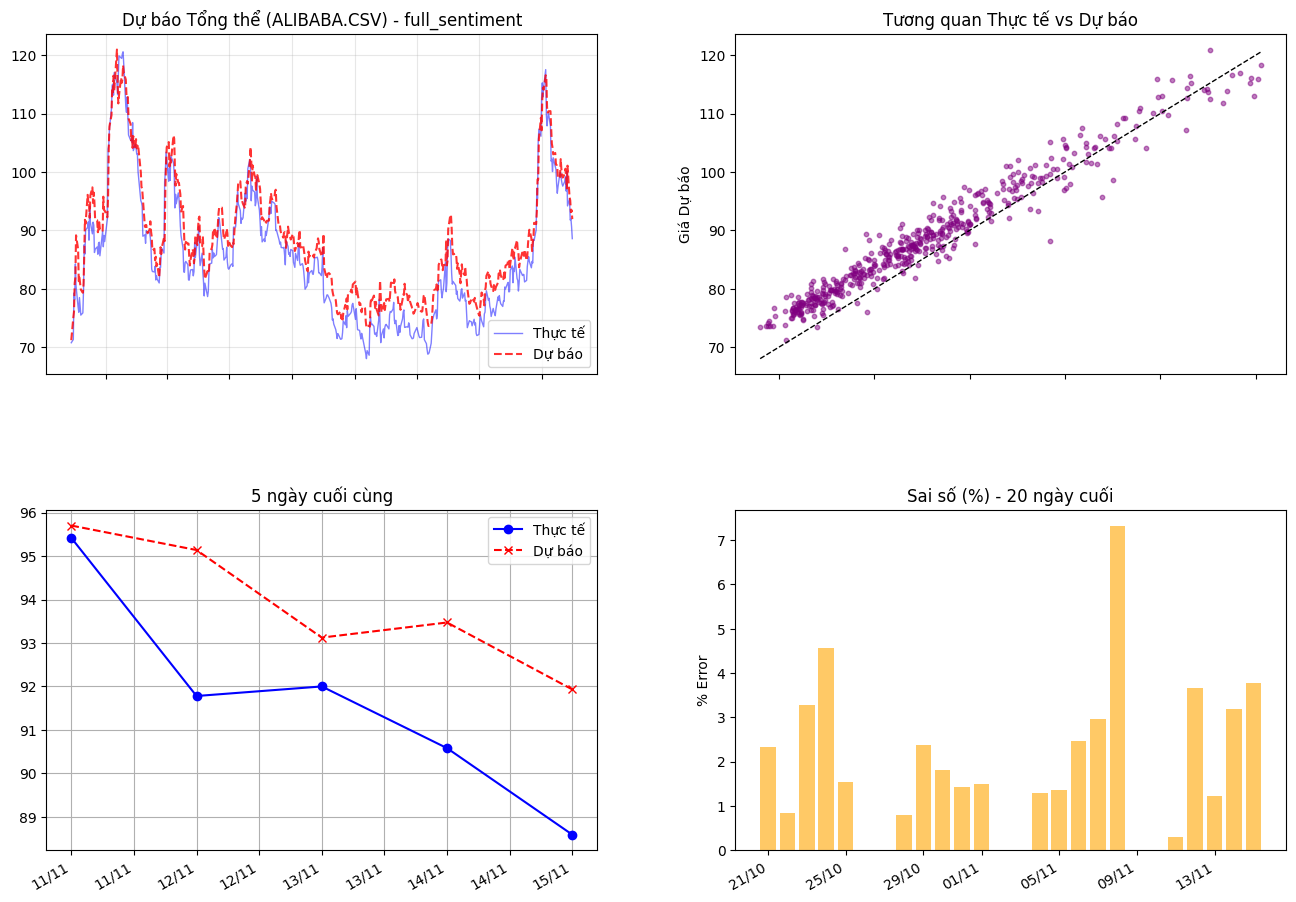


>>> ĐANG XỬ LÝ: ALIBABA | CHẾ ĐỘ: NAN_SENTIMENT
 THỐNG KÊ FILE GỐC:
   1. Price     : 2559 dòng
   2. Sentiment : 164 dòng
   [Debug] Cột Sentiment tìm thấy: ['Date']
Training ALIBABA_nan_sentiment (Sentiment Mode)...
Epoch 1/150 - Loss: 0.099586
Epoch 20/150 - Loss: 0.023071
Epoch 40/150 - Loss: 0.017662
Epoch 60/150 - Loss: 0.017611
Epoch 80/150 - Loss: 0.016880
Epoch 100/150 - Loss: 0.016359
Epoch 120/150 - Loss: 0.015988
Epoch 140/150 - Loss: 0.012768


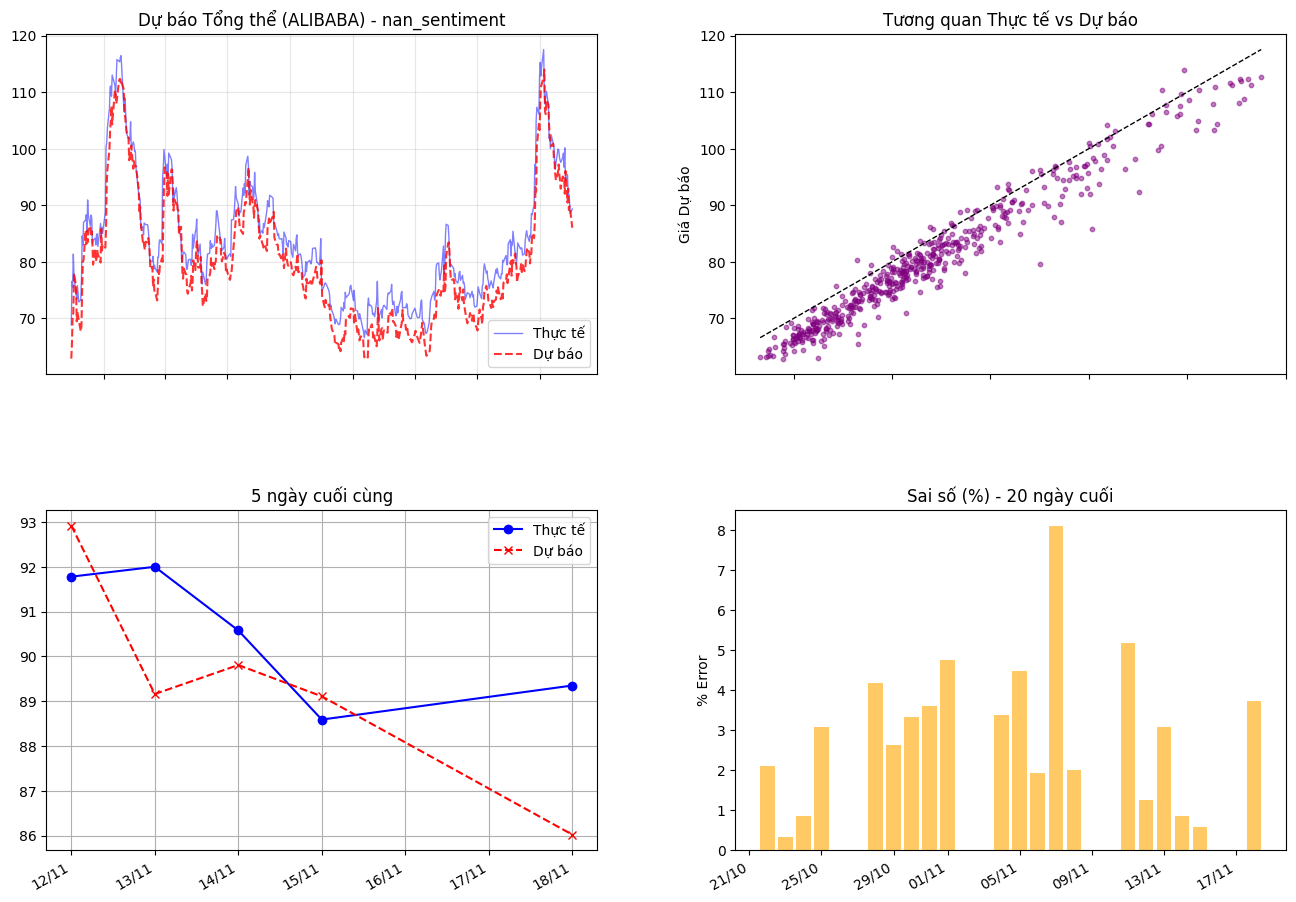


>>> ĐANG XỬ LÝ: ALIBABA | CHẾ ĐỘ: FULL_SENTIMENT
 THỐNG KÊ FILE GỐC:
   1. Price     : 2559 dòng
   2. Sentiment : 164 dòng
   [Debug] Cột Sentiment tìm thấy: ['Date']
Training ALIBABA_full_sentiment (Sentiment Mode)...
Epoch 1/150 - Loss: 0.125897
Epoch 20/150 - Loss: 0.025599
Epoch 40/150 - Loss: 0.017405
Epoch 60/150 - Loss: 0.017700
Epoch 80/150 - Loss: 0.018934
Epoch 100/150 - Loss: 0.015565
Epoch 120/150 - Loss: 0.015511
Epoch 140/150 - Loss: 0.013107


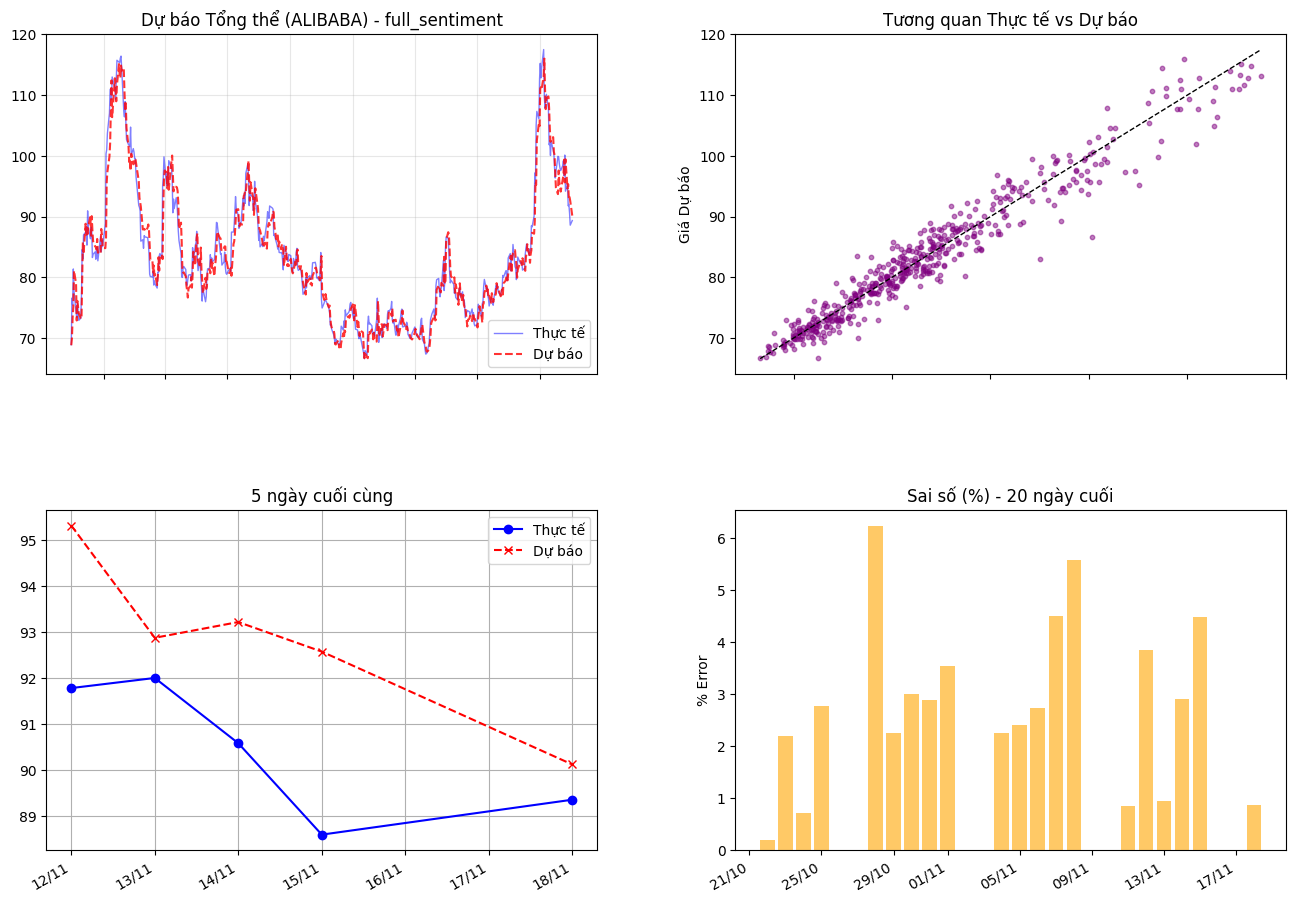


>>> ĐANG XỬ LÝ: META.CSV | CHẾ ĐỘ: NAN_SENTIMENT
 THỐNG KÊ FILE GỐC:
   1. Price     : 3204 dòng
   2. Sentiment : 1104 dòng
   [Debug] Cột Sentiment tìm thấy: ['Date']
Training META.CSV_nan_sentiment (Sentiment Mode)...
Epoch 1/150 - Loss: 0.030135
Epoch 20/150 - Loss: 0.005696
Epoch 40/150 - Loss: 0.004195
Epoch 60/150 - Loss: 0.004173
Epoch 80/150 - Loss: 0.003952
Epoch 100/150 - Loss: 0.003948
Epoch 120/150 - Loss: 0.003946
Epoch 140/150 - Loss: 0.003348


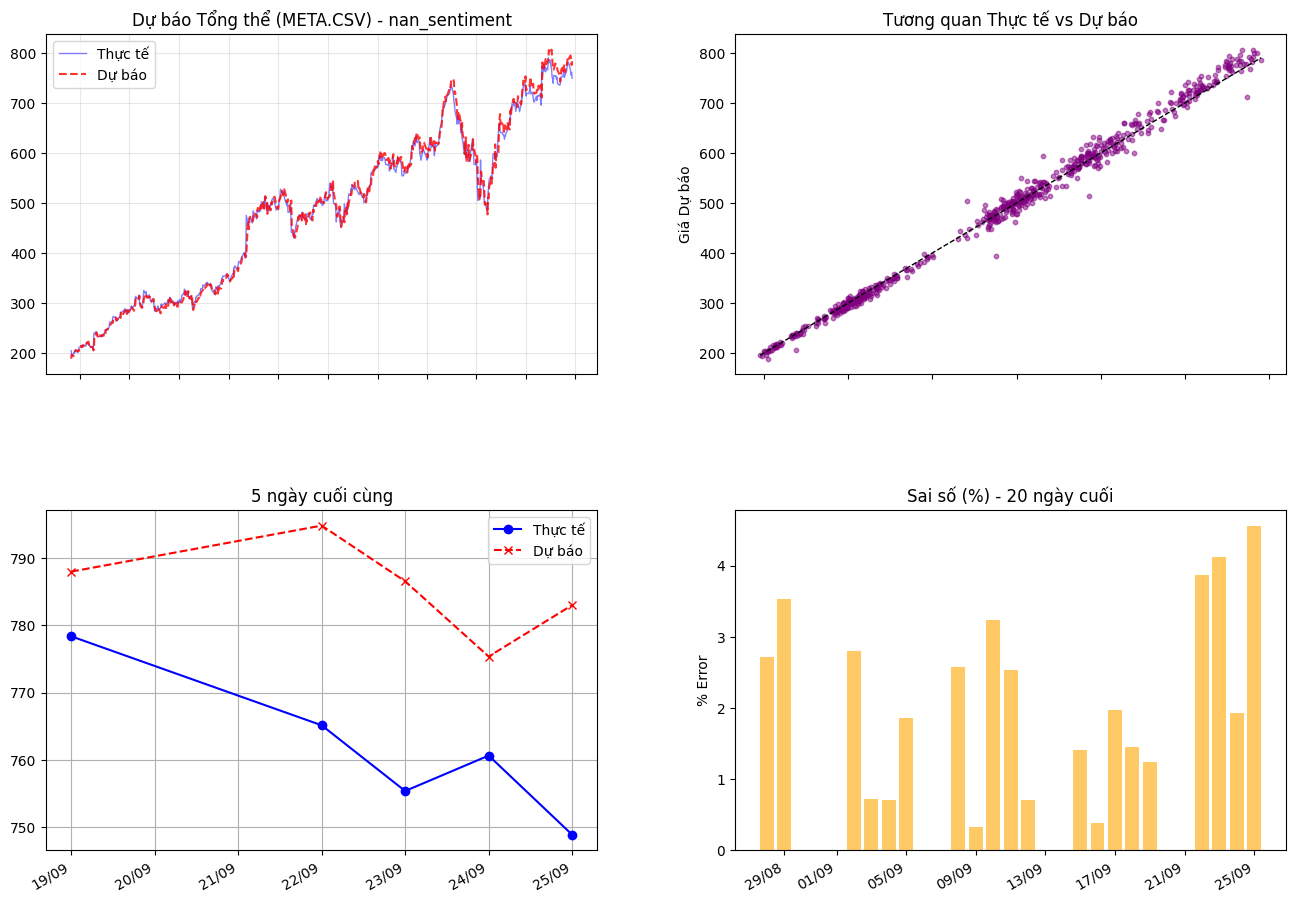


>>> ĐANG XỬ LÝ: META.CSV | CHẾ ĐỘ: FULL_SENTIMENT
 THỐNG KÊ FILE GỐC:
   1. Price     : 3204 dòng
   2. Sentiment : 1104 dòng
   [Debug] Cột Sentiment tìm thấy: ['Date']
Training META.CSV_full_sentiment (Sentiment Mode)...
Epoch 1/150 - Loss: 0.031203
Epoch 20/150 - Loss: 0.005833
Epoch 40/150 - Loss: 0.004342
Epoch 60/150 - Loss: 0.004458
Epoch 80/150 - Loss: 0.003862
Epoch 100/150 - Loss: 0.003656
Epoch 120/150 - Loss: 0.003665
Epoch 140/150 - Loss: 0.003478


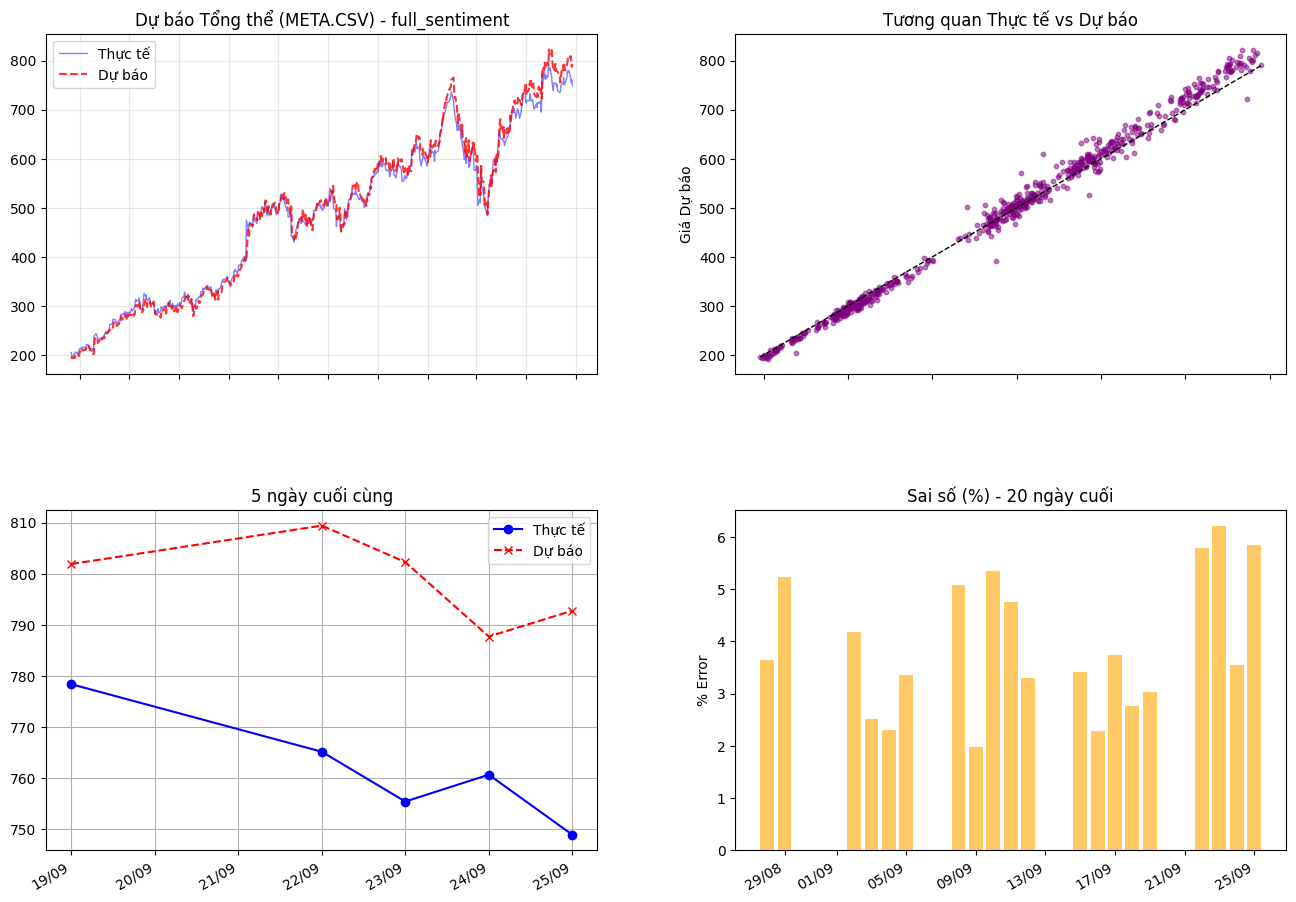


>>> ĐANG XỬ LÝ: VNM | CHẾ ĐỘ: NAN_SENTIMENT
 THỐNG KÊ FILE GỐC:
   1. Price     : 2837 dòng
   2. Sentiment : 1234 dòng
   [Debug] Cột Sentiment tìm thấy: ['Date', 'sentiment_score', 'impact_score', 'relevance_score', 'confidence', 'short_term_score', 'medium_term_score', 'sentiment_momentum', 'sentiment_volatility', 'sentiment_trend', 'prob_pos', 'prob_neg']
Training VNM_nan_sentiment (Sentiment Mode)...
Epoch 1/150 - Loss: 0.127885
Epoch 20/150 - Loss: 0.030560
Epoch 40/150 - Loss: 0.021828
Epoch 60/150 - Loss: 0.023091
Epoch 80/150 - Loss: 0.020729
Epoch 100/150 - Loss: 0.017958
Epoch 120/150 - Loss: 0.019231
Epoch 140/150 - Loss: 0.017025


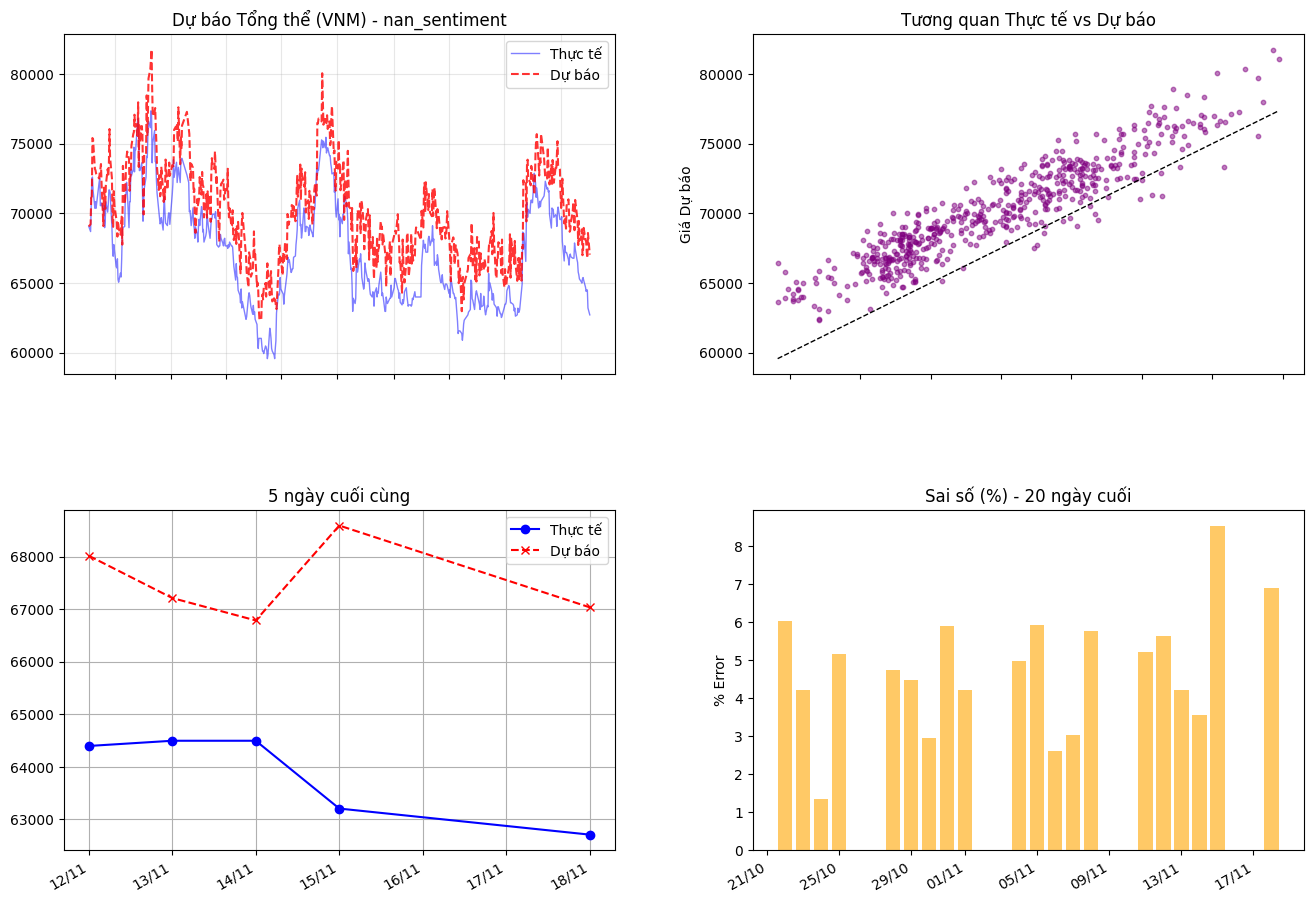


>>> ĐANG XỬ LÝ: VNM | CHẾ ĐỘ: FULL_SENTIMENT
 THỐNG KÊ FILE GỐC:
   1. Price     : 2837 dòng
   2. Sentiment : 1234 dòng
   [Debug] Cột Sentiment tìm thấy: ['Date', 'sentiment_score', 'impact_score', 'relevance_score', 'confidence', 'short_term_score', 'medium_term_score', 'sentiment_momentum', 'sentiment_volatility', 'sentiment_trend', 'prob_pos', 'prob_neg']
Training VNM_full_sentiment (Sentiment Mode)...
Epoch 1/150 - Loss: 0.205248
Epoch 20/150 - Loss: 0.025260
Epoch 40/150 - Loss: 0.017044
Epoch 60/150 - Loss: 0.019151
Epoch 80/150 - Loss: 0.020876
Epoch 100/150 - Loss: 0.016598
Epoch 120/150 - Loss: 0.017074
Epoch 140/150 - Loss: 0.014960


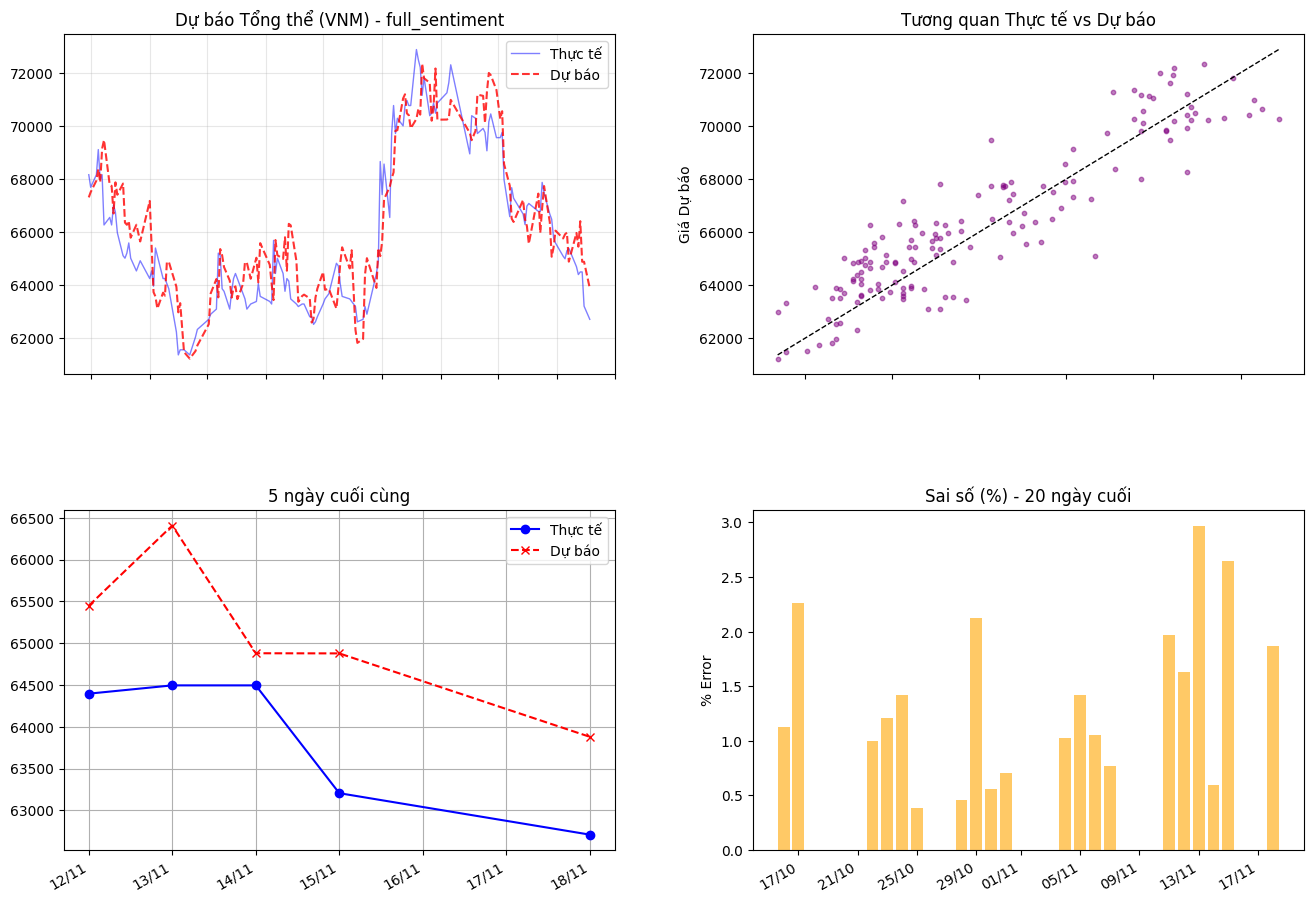


=================================== BẢNG ĐÁNH GIÁ VÀ DỰ BÁO NGÀY CUỐI ===================================

============================== KẾT QUẢ SO SÁNH CHI TIẾT ==============================


,Ticker,Mode,DA (%),MAPE (%),RMSE,MAE,R2,Actual Last,Pred Last
0,ALIBABA.CSV,nan_sentiment,51.2871,3.4618,3.6608,2.9680,0.8949,88.589996,88.111801
1,ALIBABA.CSV,full_sentiment,50.0990,4.2742,4.0041,3.5239,0.8742,88.589996,91.931503
2,ALIBABA,nan_sentiment,51.2871,4.4111,4.2269,3.6275,0.8505,89.349998,86.021896
3,ALIBABA,full_sentiment,52.0792,2.2352,2.6189,1.9226,0.9426,89.349998,90.116997
4,META.CSV,nan_sentiment,50.1577,1.9782,14.0265,9.9196,0.9925,748.909973,783.010498
5,META.CSV,full_sentiment,49.5268,2.6095,17.8529,13.0854,0.9878,748.909973,792.772827
6,VNM,nan_sentiment,43.8503,4.3810,3196.6551,2914.3623,0.2859,62709.300781,67033.359375
7,VNM,full_sentiment,50.6579,1.5725,1250.3348,1037.7350,0.8196,62709.300781,63879.929688


Bảng kết quả đã được lưu thành ảnh tại: ..\..\CHART\DLINEAR+NODE\sentiment_results_advanced.png


In [12]:
# =============================================================================
# CELL 5: CHẠY TOÀN BỘ HỆ THỐNG (ĐÃ ĐỒNG BỘ THAM SỐ PROCESSOR)
# =============================================================================

import os
all_metrics_results = []

# 1. Khai báo danh sách file (Tránh lỗi NameError)
valid_files = [f for f in os.listdir(PRICE_DIR) if f.endswith('.csv')]
sentiment_files = [f for f in os.listdir(SENTIMENT_DIR) if f.endswith('.csv')]

# Lọc chỉ lấy 1 file duy nhất cho mỗi mã
seen_tickers = set()
filtered_files = []
for f in valid_files:
    t = f.split('_')[0].upper()
    if t not in seen_tickers:
        filtered_files.append(f)
        seen_tickers.add(t)
valid_files = filtered_files
print(f"Bắt đầu xử lý {len(valid_files)} mã cổ phiếu...")

scenarios = ['nan_sentiment', 'full_sentiment']

for filename in valid_files:
    ticker_core = filename.split('_')[0].upper()
    sentiment_file = next((s for s in sentiment_files if ticker_core in s.upper()), None)
    
    if sentiment_file is None: continue

    for mode in scenarios:
        print(f"\n>>> ĐANG XỬ LÝ: {ticker_core} | CHẾ ĐỘ: {mode.upper()}")
        try:
            processor = DataProcessor()
            df_raw = processor.load_and_merge_data(os.path.join(PRICE_DIR, filename), 
                                                   os.path.join(SENTIMENT_DIR, sentiment_file))
            
            # Phân tách kịch bản
            sent_cols = [c for c in df_raw.columns if any(w in c.lower() for w in ['score', 'impact', 'relevance'])]
            if mode == 'full_sentiment':
                df_merged = df_raw.dropna(subset=sent_cols).copy()
            else:
                df_merged = df_raw.copy()

            if len(df_merged) < SEQ_LEN + 15: continue

            # Feature Engineering
            price_f, sent_f, targets = processor.create_features(df_merged)
            X_p, X_s, y = processor.prepare_sequences(price_f, sent_f, targets, ticker_core, SEQ_LEN)
            
            # Chia tập dữ liệu
            train_size = int(len(y) * 0.8)
            X_p_train, X_p_val = torch.FloatTensor(X_p[:train_size]), torch.FloatTensor(X_p[train_size:])
            X_s_train, X_s_val = torch.FloatTensor(X_s[:train_size]), torch.FloatTensor(X_s[train_size:])
            y_train, y_val = torch.FloatTensor(y[:train_size]), torch.FloatTensor(y[train_size:])

            # Huấn luyện
            model = SentimentDLinearNodeModel(seq_len=SEQ_LEN, price_dim=X_p.shape[2], sentiment_dim=X_s.shape[2]).to(DEVICE)
            model_save_name = f"{ticker_core}_{mode}"
            history, saved_path = train_model(model, DataLoader(TensorDataset(X_p_train, X_s_train, y_train), batch_size=BATCH_SIZE, shuffle=True), 
                                              DataLoader(TensorDataset(X_p_val, X_s_val, y_val), batch_size=BATCH_SIZE), 
                                              model_save_name, epochs=EPOCHS)

            # --- DỰ BÁO VÀ ĐÁNH GIÁ (TRUYỀN THÊM PROCESSOR) ---
            model.load_state_dict(torch.load(os.path.abspath(saved_path), map_location=DEVICE))
            val_dates = df_merged['Date'].values[train_size + SEQ_LEN:]
            
            # LỜI GỌI HÀM QUAN TRỌNG: Cần có 'processor=processor'
            metrics = visualize_prediction(
                model=model,
                X_p_tensor=X_p_val,
                X_s_tensor=X_s_val,
                y_tensor=y_val,
                stock_name=ticker_core,
                dates=val_dates,
                mode=mode,
                filename=filename,
                processor=processor
            )
            if metrics:
                all_metrics_results.append(metrics)

        except Exception as e:
            print(f" Lỗi tại {ticker_core} ({mode}): {str(e)}")
            continue

# Hiển thị và lưu bảng tổng hợp
if all_metrics_results:
    print("\n" + "="*35 + " BẢNG ĐÁNH GIÁ VÀ DỰ BÁO NGÀY CUỐI " + "="*35)
    summary_df = pd.DataFrame(all_metrics_results)
    
    # Sắp xếp lại thứ tự cột cho dễ nhìn
    display_cols = [
        'Ticker', 'Mode', 'DA (%)', 'MAPE (%)', 
        'RMSE', 'MAE', 'R2', 'Actual Last', 'Pred Last'
    ]
    
    summary_df = summary_df[display_cols].round(4)
    
    print("\n" + "="*30 + " KẾT QUẢ SO SÁNH CHI TIẾT " + "="*30)
    display(summary_df)
    
    # --- LƯU BẢNG KẾT QUẢ RA ẢNH ---
    fig, ax = plt.subplots(figsize=(14, 4)) # Điều chỉnh kích thước
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    # Lưu ảnh
    image_filename = "sentiment_results_advanced.png"
    image_path = os.path.join(CHART_DIR, image_filename)
    plt.savefig(image_path, bbox_inches='tight', dpi=150)
    plt.close(fig)
    print(f"Bảng kết quả đã được lưu thành ảnh tại: {image_path}")